In [ ]:
# Imports

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, sigma = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1] 
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + sigma* epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mu = layers.Dense(latent_dim, name="mu")(x)
sigma = layers.Dense(latent_dim, name="sigma")(x)
z = Sampling()([mu, sigma])
encoder = keras.Model(encoder_inputs, [mu, sigma, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            mu, sigma, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            
            KL_div = 0.5 *(tf.square(mu) + tf.square(sigma) - tf.math.log(tf.square(sigma)) - 1)

            marginal_likelihood = reconstruction_loss * 28 * 28
            KL_div = tf.reduce_mean(KL_div)

            ELBO = marginal_likelihood + KL_div
            total_loss = ELBO

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": KL_div,
        }

In [18]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 96s 176ms/step - loss: 186.5754 - reconstruction_loss: 0.2348 - kl_loss: 2.5068
Epoch 2/30
547/547 [==============================] - 96s 176ms/step - loss: 178.5287 - reconstruction_loss: 0.2238 - kl_loss: 3.0986
Epoch 3/30
547/547 [==============================] - 96s 176ms/step - loss: 176.2824 - reconstruction_loss: 0.2207 - kl_loss: 3.2787
Epoch 4/30
547/547 [==============================] - 96s 176ms/step - loss: 170.6255 - reconstruction_loss: 0.2138 - kl_loss: 3.0183
Epoch 5/30
547/547 [==============================] - 96s 176ms/step - loss: 166.8842 - reconstruction_loss: 0.2089 - kl_loss: 3.0912
Epoch 6/30
547/547 [==============================] - 96s 176ms/step - loss: 164.5655 - reconstruction_loss: 0.2060 - kl_loss: 3.0464
Epoch 7/30
547/547 [==============================] - 96s 175ms/step - loss: 161.2519 - reconstruction_loss: 0.2018 - kl_loss: 3.0782
Epoch 8/30
547/547 [==============================] - 96s 175m

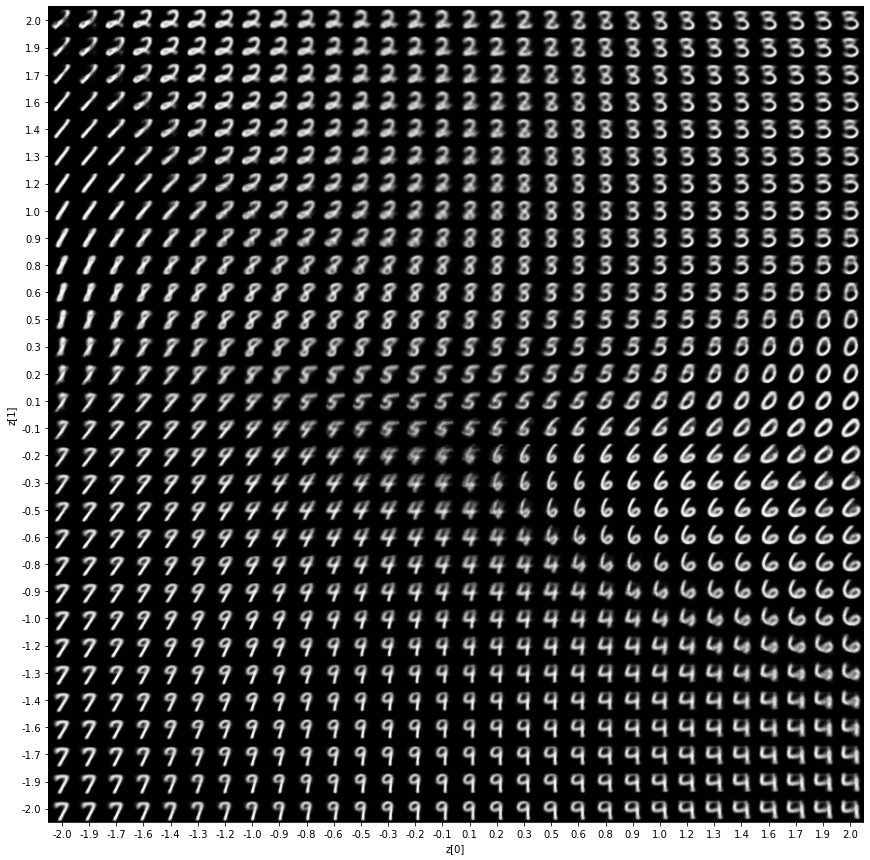

In [20]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

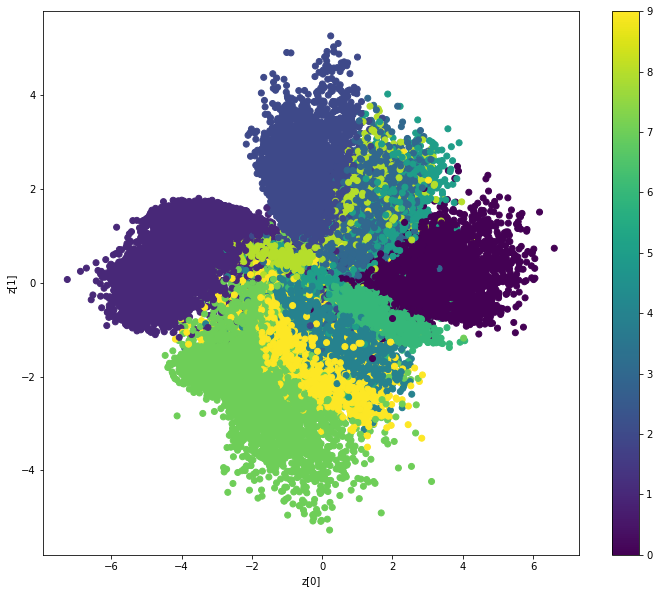

In [21]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)